# Statistical Analysis

In this workbook, we will look at modelling experimental results with Monte-Carlo methods, and how this can be used to interpret the results of a real experiment.

In this workbook, we will develop models of experimental uncertainty, which we can use to generate large numbers of "pseudo-experiments". A pseudo-experiment is just a Monte-Carlo trial which represents the outcome of a single measurement.  By generating large numbers of pseudo-experiments, we can predict experimental outcomes. We can then compare real measurements with the prediction made by the model.

## Confidence Intervals

Suppose we conduct an experiment to measure an unknown parameter $\theta$.  The experiment will produce an observation $x$.  We want to construct a model that relates $x$ to $\theta$, that we can use to infer knowledge about $\theta$ from our observation.  If this sounds a bit convoluted, that's because you will have encountered many measurements where the relationship between $\theta$ and $x$ is trivial. For example, when we measure the length of an object, our best estimate of $\theta$ is simply the mean of measurements $x$. However, there are various categories of experiment where the relationship is less straightfoward, as we shall see.

Our goal is to is to find a range of $\theta$, that is compatible with the measurement to a specified degree of confidence. We can define the interval $[\theta_1, \theta_2]$ as containing the true value of $\theta$ with probability $\beta$. This is called a confidence interval, and there are a number of ways to compute it.  Here we will construct a model using random number generation that, given an assumption of $\theta$, will generate probability distributions of $x$.  By comparing these distributions with an actual observation, $x0$, we can obtain the confidence interval as follows :

1. Scan a range of hypotheses for $\theta$
2. For each hypothesis, find the fraction of pseudo-experiments that give $x>x_0$.  Call this $f_{>}(\theta)$. 
3. Likewise, find the fraction of pseudo-experiments that give $x<x_0$.  Call this $f_{<}(\theta)$.
4. Now find $\theta_1$ such that $f_{>}(\theta_1) = \alpha = \frac{1-\beta}{2}$.
5. Finally, find $\theta_2$ such that $f_{<}(\theta_2) = \alpha = \frac{1-\beta}{2}$.

Our confidence interval is then $[\theta_1,\theta_2]$.

Note that to define the limits of the confidence interval, we find the fraction of pseudo-experiments that give a result _outside_ the interval, which leads to the use of $\alpha = \frac{1-\beta}{2}$, ie. the fraction of the distribution in one of the tails.

## Normal Error Distribution

As a simple example, we will consider a measurement with a standard Gaussian-distributed uncertainty. This is a trivial example, but it will serve to illustrate the method.

Here the PDF of obtained measurements $x$, given true value $\theta$ and variance $\sigma^2$ is :

$$ \Large f(X|\theta) = \frac{1}{\sigma\sqrt{2 \pi}}e^\frac{-(X-\theta)^2}{2\sigma^2}$$

We can easily generate this using numpy's built-in normal random number generator.  The function below will generate $N_{expt}$ pseudo-experiments, and return the PDF in the form of a histogram with specified number of bins and range.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# a function to generate pseudo-experiment results for a given hypothesis
# they are returned as a histogram normalised to 1, for convenience later
def gaussianPDF(theta, sigma, nexpt, nbins, pdf_range):
    results = np.random.normal(theta, sigma, nexpt)
    hist, bins = np.histogram(results, nbins, pdf_range)
    return hist/nexpt, bins

We can demonstrate this has the expected result.

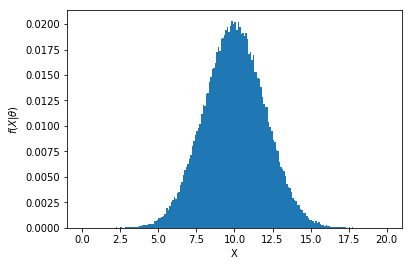

In [3]:
# call the function for mean=10, sigma=2
hist, bins = gaussianPDF(10., 2.0, 100000, 200, [0., 20.])

# make a histogram plot
# since we already have a histogram we just copy the contents to the plot using the 'weights' argument
plt.hist(bins[:-1], bins, weights=hist, label='pdf')
plt.xlabel("X")
plt.ylabel(r"$f(X|\theta)$")
plt.show()

For the PDF in this example, we could calculate $f_{>}(\theta)$ and $f_{<}(\theta)$ using scipy.stats, using its builtin cumulative and survival functions.  However, here we are interested in using a Monte-Carlo method, since this will be applicable to more complex (non Gaussian) distributions.

First we need some functions to calculate $f_{>}$ and $f_{<}$ from a given PDF, $f(X|\theta)$. These functions will take the histogram as argument, along with the list of bins and the measured value $x_0$. We use numpys searchsorted() function to find the index of the bin containing $x_0$. Then use numpy array slicing to sum the histogram over the desired bins.

In [193]:
# fraction of a histogram above a given value x0
def fAbove(hist, bins, x0):
    i = np.searchsorted(bins, x0)
    return np.sum(hist[i::1])

# fraction of a histogram below a given value x0
def fBelow(hist, bins, x0):
    i = np.searchsorted(bins, x0)
    return np.sum(hist[:i:1])

We should check these functions behave as expected, using the test PDF we created earlier...

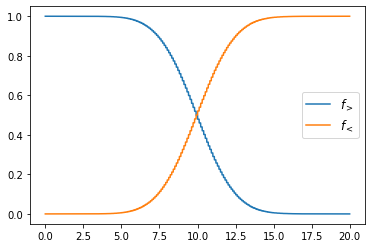

In [194]:
# generate a range of x to scan
xs = np.arange(0., 20., 0.01)

# these will store the fractions above and fractions below
fas = []
fbs = []

# loop over the range of x and calculeate the fraction of the histogram above/below
for x in xs:
    fas.append(fAbove(hist, bins, x))
    fbs.append(fBelow(hist, bins, x))

# plot the results
plt.plot(xs, fas, label=r'$f_>$')
plt.plot(xs, fbs, label=r'$f_<$')
plt.legend(fontsize='large')
plt.show()

We can write some functions to find $\theta_1$ and $\theta_2$ according to steps 4 and 5 :

4. Now find $\theta_1$ such that $f_{>}(\theta_1) = \alpha = \frac{1-\beta}{2}$.
5. Finally, find $\theta_2$ such that $f_{<}(\theta_2) = \alpha = \frac{1-\beta}{2}$.


In [195]:
# find value of f_below that matches alpha and return array index
def thetaLow(f_aboves, alpha):
    
    # np.searchsorted will find the position where a value should be inserted to preserve the order
    # add one gives the first bin which is greater than alpha
    i = np.searchsorted(f_aboves, alpha)
    return i

# find value of f_above that matches alpha and return array index
def thetaHigh(f_belows, alpha):
    
    # searchsorted expects an array in ascending order
    tmp = np.sort(f_belows)
    
    # now we can do the same as before
    i = np.searchsorted(tmp, alpha)
    
    # but return the correct index of the original array
    return len(tmp)-i

Now we can write a function that will find the confidence interval using the method described above. It has quite a few arguments :
* `x0`, the measured value
* `theta_range`, the range of $\theta$ to scan
* `n_theta`, number of steps in the scan
* `pdf`, function to call to generate $x$ given $\theta$
* `beta`, which defines the confidence

Since we want to use this function for a range of experiment models, we are going to use a trick of passing a function to a function to generate the PDF of $x$.

In [198]:
def confidenceInterval(x0, theta_range, n_theta, pdf, beta):

    # generate the range of theta to scan
    ts=np.linspace(theta_range[0], theta_range[1], n_theta)

    # arrays to store the fraction of expts above/below x0
    f_aboves = []
    f_belows = []

    # scan theta
    for theta in ts:
        
        # generate the PDF of results for this hypothesis
        hist, bins = pdf(theta)
        
        # calculate fraction of expts above/below x0
        f_aboves.append(fAbove(hist, bins, x0))
        f_belows.append(fBelow(hist, bins, x0))
    
    # account for the fact that fAbove & fBelow each cover (1-beta)/2
    # ie. find the fraction of the PDF *outside* the interval
    alpha = (1-beta)/2

    # find confidence interval
    t1 = ts[thetaLow(f_aboves, alpha)]
    t2 = ts[thetaHigh(f_belows, alpha)]
    
    # make a quick plot to illustrate the results 
    plt.plot(ts, f_aboves, label="% expts > x0")
    plt.plot(ts, f_belows, label="% expts < x0")
    plt.vlines(t1, 0., 1., linestyle='dotted')
    plt.vlines(t2, 0., 1., linestyle='dotted')
    plt.hlines(alpha, theta_range[0], theta_range[1], linestyle='dotted')
    plt.legend()
    plt.xlabel(r"$\theta$")
    plt.ylabel(r"$f(\theta)$")
    plt.show()

    return t1, t2


Now we can compute a confidence interval for an example. Let's say we measured a value of $x_0=10.3$, our uncertainty model has $\sigma=0.5$, and we require a confidence interval given by $\beta=0.6827$ (which is equivalent to 1 standard deviation for a Gaussian distribution).

First, we setup the PDF generating function with appropriate arguments for the problem we are going to solve, and assign this to a variable using a lambda function before we pass it to `confidenceInterval()`.  This is simply so we can write a general function for finding the confidence interval, without restricting it to a particular PDF.

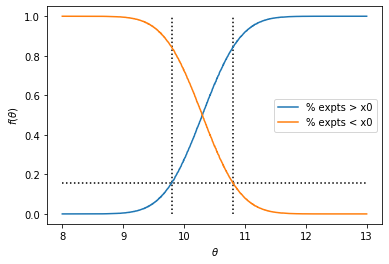

(9.8, 10.805)

In [199]:
modelpdf = lambda x:gaussianPDF(x, sigma=0.5, nexpt=int(1e5), nbins=200, pdf_range=[0., 20.])
confidenceInterval(x0=10.3, theta_range=[8., 13.], n_theta=1001, pdf = modelpdf, beta=0.6827)

This should come as no surprise...  Given a single measurement, $x_0=10.3$, and our assumed standard deviation of 0.5, we would expect the true value lies between $9.8 \leq \theta \leq 10.8$ at the 1-sigma (or 68% confidence) level.

Note that the values returned for the confidence interval are reported with a resolution determined by the size of the steps when scanning $\theta$. In this example, we used bins with a width of 0.0025. The accuracy of the result also depends on the number of toy experiments, and the precision of the histogram used to bin the underlying PDF.

For normally distributed uncertainties, we can use standard error propagation to estimate the uncertainty on our final result.  So you might wonder what is the point of this exercise...  The key is when we encounter uncertainties that are **not** normally distributed - in such cases, standard error propagation may be invalid, and Monte-Carlo methods can be useful.

## Poisson Distributed Variables

In the previous example, the PDF $f(X|\theta)$ arose from normally-distributed experimental errors. However, variation in $x$ can also arise from an inherently random process. For example, noise in an electronic circuit may result in a fixed _average_ rate of pulses, but the number observed in a given period of time will follow a Poisson distribution. Now $\theta$ is the average rate, while $x$ is the actual number of observed pulses in fixed time interval.  We can model this as before, by writing a function to generate the PDF of observations $x$ given $\theta$.

In [200]:
def poissonPDF(mu, nexpt, nbins, pdf_range):
    results = np.random.poisson(mu, nexpt)
    hist, bins = np.histogram(results, nbins, pdf_range)
    return hist/nexpt, bins

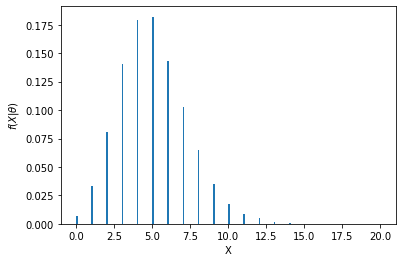

In [201]:
hist, bins = poissonPDF(5., 10000, 200, [0., 20.])
plt.hist(bins[:-1], bins, weights=hist, label='pdf')
plt.xlabel("X")
plt.ylabel(r"$f(X|\theta)$")
plt.show()

Now let's consider the case where we observe a relatively large number of events, in the regime where the Poisson can be approximated by a Gaussian.

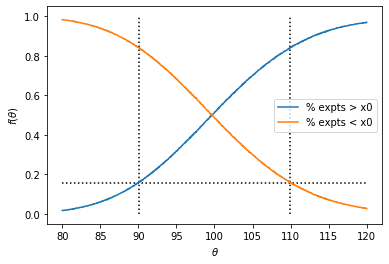

(90.08, 109.96000000000001)

In [203]:
modelpdf = lambda x:poissonPDF(x, nexpt=int(1e5), nbins=200, pdf_range=[50., 150.])
confidenceInterval(x0=100, theta_range=[80., 120.], n_theta=1001, pdf=modelpdf, beta=0.6827)

Again, this is not far from what we might expect - if we assume a standard deviation of $\sqrt{100}$.

In the case where the observation is small, however, we see something different.


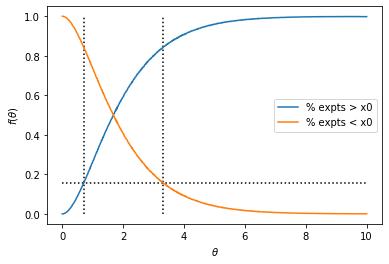

(0.71, 3.31)

In [206]:
modelpdf = lambda x:poissonPDF(x, nexpt=int(1e5), nbins=200, pdf_range=[0., 20.])
confidenceInterval(x0=2, theta_range=[0., 10.], n_theta=1001, pdf=modelpdf, beta=0.6827)

Clearly, the confidence interval has become asymmetric.  This is unsurprising since the distribution has a physical boundary at zero.  This becomes even more apparent if we require greater confidence in our measurement than the 1-sigma equivalent we have used so far, for example if we require confidence equivalent to 3-sigma, ie. $\beta = 99.73 \%$.


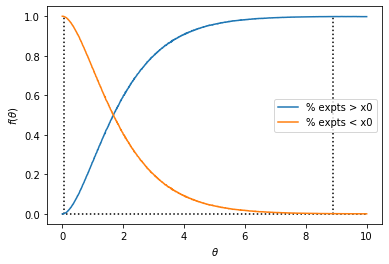

(0.06, 8.9)

In [207]:
confidenceInterval(x0=2, theta_range=[0.,10.], n_theta=1001, pdf=modelpdf, beta=0.9973)